In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("done")

2025-06-01 03:08:11.747431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748747291.973533      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748747292.043187      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done


In [2]:
X = []
y = []

# Define folder paths and corresponding labels
paths_labels = {
    'arachnoid-cyst': 0,
    'cerebellah-hypoplasia': 1,
    'encephalocele': 2,
    'mild-ventriculomegaly': 3,
    'moderate-ventriculomegaly': 4,
    'normal': 5,
    'severe-ventriculomegaly': 6,
}

for folder, label in paths_labels.items():
    path = f"/kaggle/input/dataset-kenza/train/{folder}"
    os.chdir(path)
    for i in tqdm(os.listdir()):
        img = cv2.imread(i)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(label)
for folder, label in paths_labels.items():
    path = f"/kaggle/input/dataset-kenza/valid/{folder}"
    os.chdir(path)
    for i in tqdm(os.listdir()):
        img = cv2.imread(i)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(label)

X = np.array(X) / 255.0  # Normalize
y = to_categorical(y, num_classes=7)

100%|██████████| 13/13 [00:00<00:00, 165.52it/s]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("done")


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
train_gen = datagen.flow(X_train, y_train, batch_size=32)
print("done")

done
done


In [5]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze some layers
for layer in vgg.layers[:15]:
    layer.trainable = False
for layer in vgg.layers[15:]:
    layer.trainable = True

def create_model(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

FC_Head = create_model(vgg, 7)
model = Model(inputs=vgg.input, outputs=FC_Head)



model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("done")


I0000 00:00:1748747663.133625      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
done


In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
print("done")



history = model.fit(train_gen,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=[reduce_lr, early_stop])



model.save('/kaggle/working/maladie_classifier.h5')
print("done")

done


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748747701.648531      99 service.cc:148] XLA service 0x7973840050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748747701.649550      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748747702.284240      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.1250 - loss: 2.8910 

I0000 00:00:1748747712.726660      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 748ms/step - accuracy: 0.2400 - loss: 2.4793 - val_accuracy: 0.1917 - val_loss: 1.9296 - learning_rate: 1.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step - accuracy: 0.3666 - loss: 1.9020 - val_accuracy: 0.1650 - val_loss: 2.0367 - learning_rate: 1.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - accuracy: 0.4751 - loss: 1.5938 - val_accuracy: 0.3592 - val_loss: 1.7670 - learning_rate: 1.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - accuracy: 0.4778 - loss: 1.5088 - val_accuracy: 0.4272 - val_loss: 1.6486 - learning_rate: 1.0000e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 327ms/step - accuracy: 0.4761 - loss: 1.5123 - val_accuracy: 0.4029 - val_loss: 1.5968 - learning_rate: 1.0000e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.5819 - loss: 1.2417 - val_accuracy: 0.4587 - val_loss: 1.4661 - learning_rate: 1.0000e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.5786 - l

In [7]:


history = model.fit(train_gen,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    callbacks=[reduce_lr, early_stop])


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - accuracy: 0.8529 - loss: 0.3919 - val_accuracy: 0.8471 - val_loss: 0.4504 - learning_rate: 7.8125e-07
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.8794 - loss: 0.3943 - val_accuracy: 0.8471 - val_loss: 0.4596 - learning_rate: 7.8125e-07
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.8768 - loss: 0.3779 - val_accuracy: 0.8447 - val_loss: 0.4692 - learning_rate: 7.8125e-07
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8671 - loss: 0.3613
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.8672 - loss: 0.3619 - val_accuracy: 0.8422 - val_loss: 0.4702 - learning_rate: 7.8125e-07
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - accuracy: 0.8636 - loss: 0.3700 - val_accuracy: 0.8350 - val_loss: 0.4783 - learning_rate: 3.9062e-07
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.85

In [8]:
model.save('/kaggle/working/maladie_classifier_v1.h5')
print("done")

done


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
✅ Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.83      0.88        42
           1       0.60      0.76      0.67        33
           2       0.90      0.80      0.84        54
           3       0.74      0.90      0.81        68
           4       0.90      0.85      0.88       100
           5       0.97      0.97      0.97        76
           6       0.81      0.67      0.73        39

    accuracy                           0.85       412
   macro avg       0.84      0.82      0.83       412
weighted avg       0.86      0.85      0.85       412

✅ Confusion Matrix:

[[35  2  0  1  2  0  2]
 [ 1 25  2  3  1  1  0]
 [ 0  2 43  5  2  0  2]
 [ 1  3  0 61  3  0  0]
 [ 1  7  2  3 85  0  2]
 [ 0  1  0  1  0 74  0]
 [ 0  2  1  8  1  1 26]]


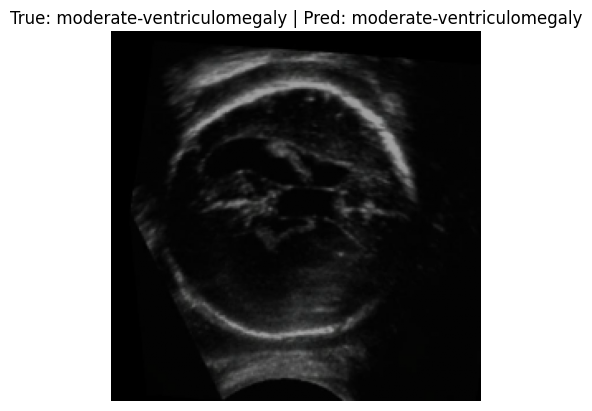

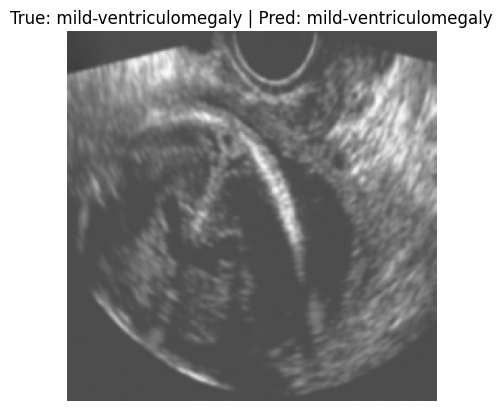

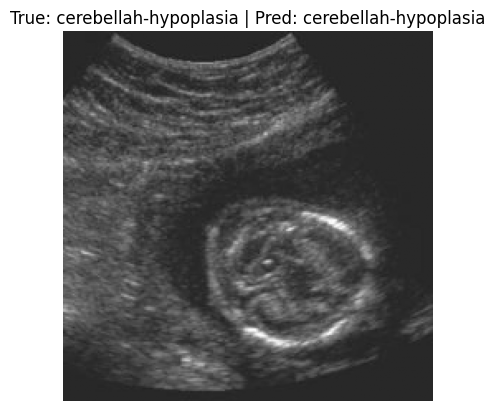

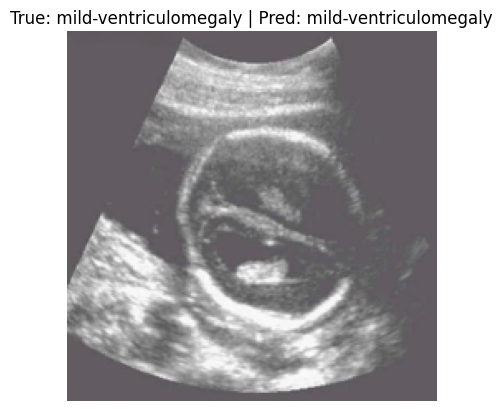

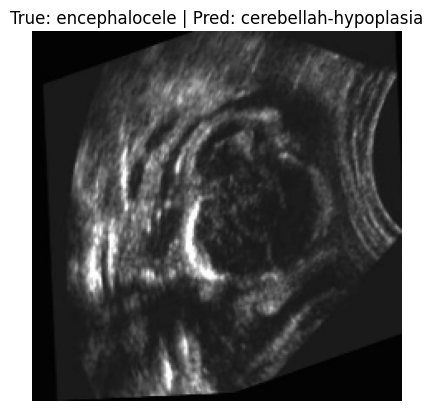

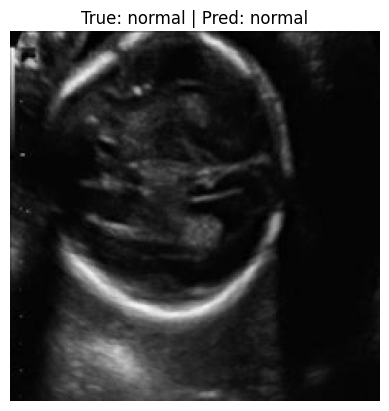

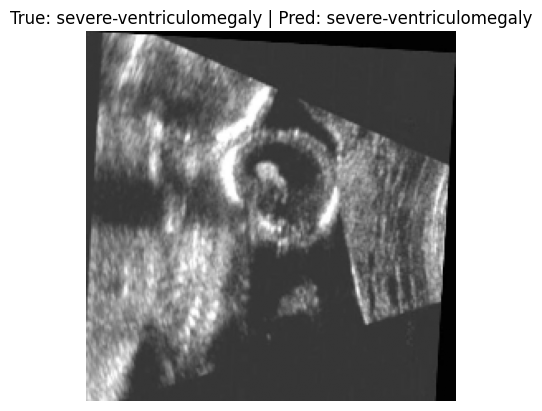

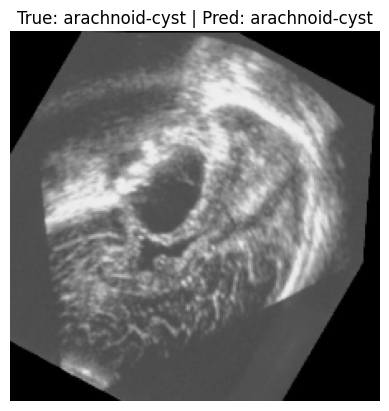

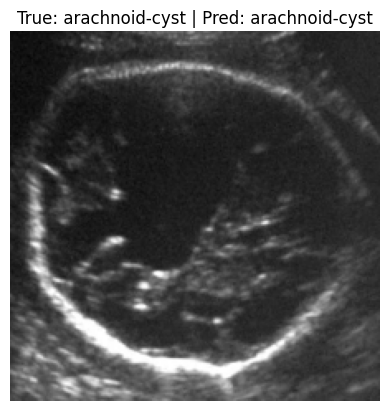

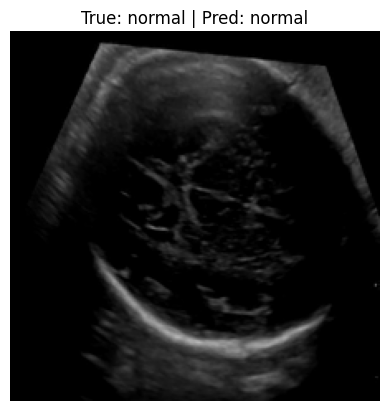

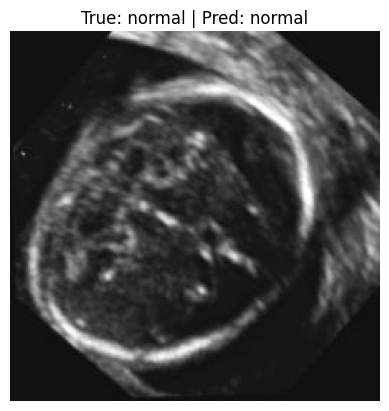

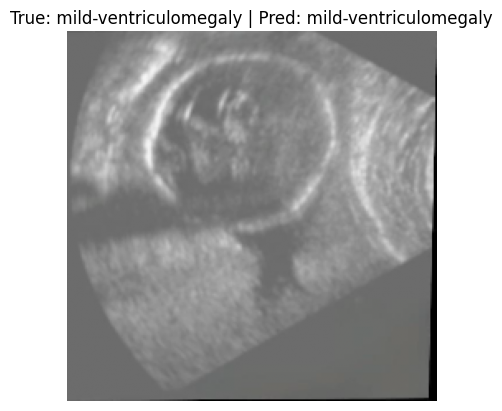

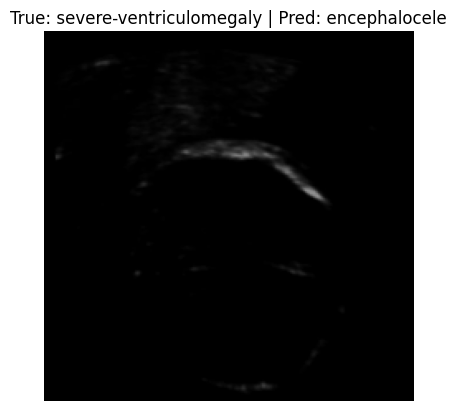

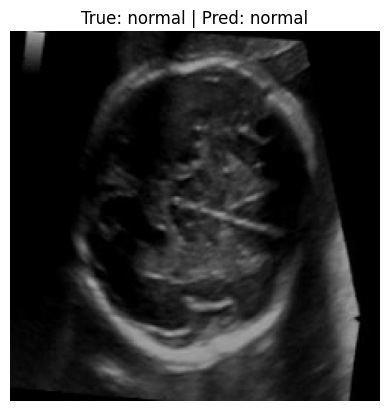

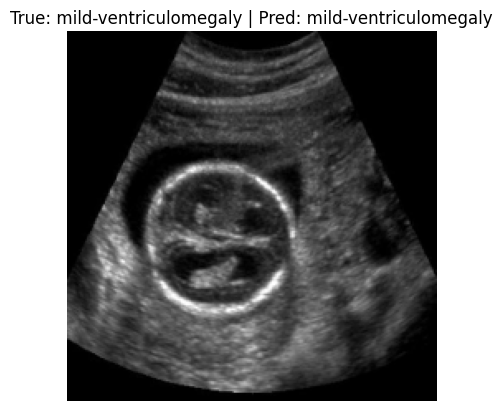

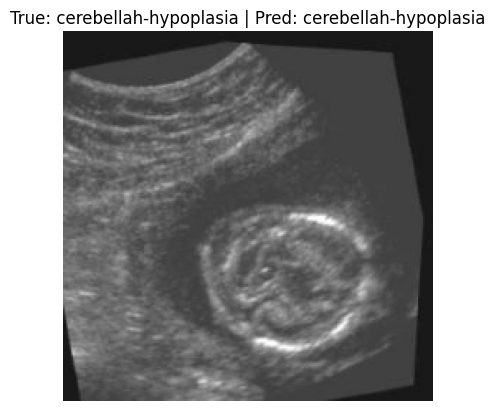

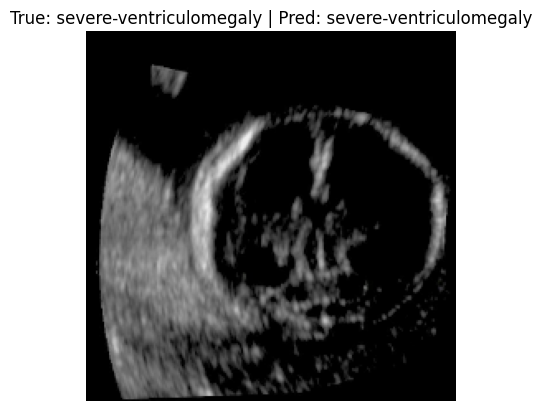

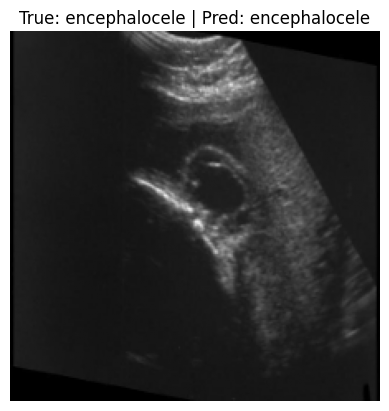

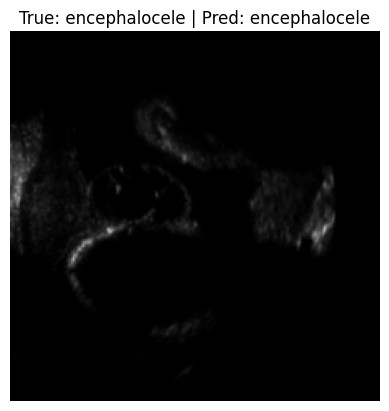

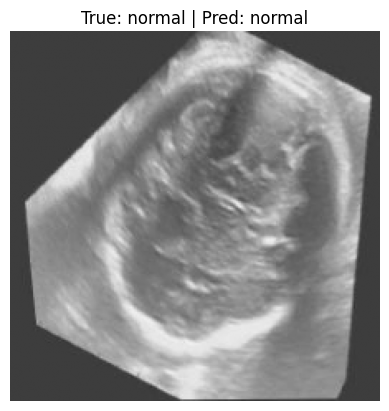

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Make predictions
predictions = model.predict(X_test)

# Step 2: Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(y_test, axis=1)

# Step 3: Evaluate the model
print("✅ Classification Report:\n")
print(classification_report(true_classes, predicted_classes))

print("✅ Confusion Matrix:\n")
print(confusion_matrix(true_classes, predicted_classes))

# Optional: Class names
class_names = [
    'arachnoid-cyst',
    'cerebellah-hypoplasia',
    'encephalocele',
    'mild-ventriculomegaly',
    'moderate-ventriculomegaly',
    'normal',
    'severe-ventriculomegaly',
]

# Step 4: Visualize some predictions
for i in range(20):
    plt.imshow(X_test[i])
    plt.title(f"True: {class_names[true_classes[i]]} | Pred: {class_names[predicted_classes[i]]}")
    plt.axis('off')
    plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
✅ Rapport de classification :

                           precision    recall  f1-score   support

           arachnoid-cyst       0.92      0.83      0.88        42
    cerebellah-hypoplasia       0.60      0.76      0.67        33
            encephalocele       0.90      0.80      0.84        54
    mild-ventriculomegaly       0.74      0.90      0.81        68
moderate-ventriculomegaly       0.90      0.85      0.88       100
                   normal       0.97      0.97      0.97        76
  severe-ventriculomegaly       0.81      0.67      0.73        39

                 accuracy                           0.85       412
                macro avg       0.84      0.82      0.83       412
             weighted avg       0.86      0.85      0.85       412



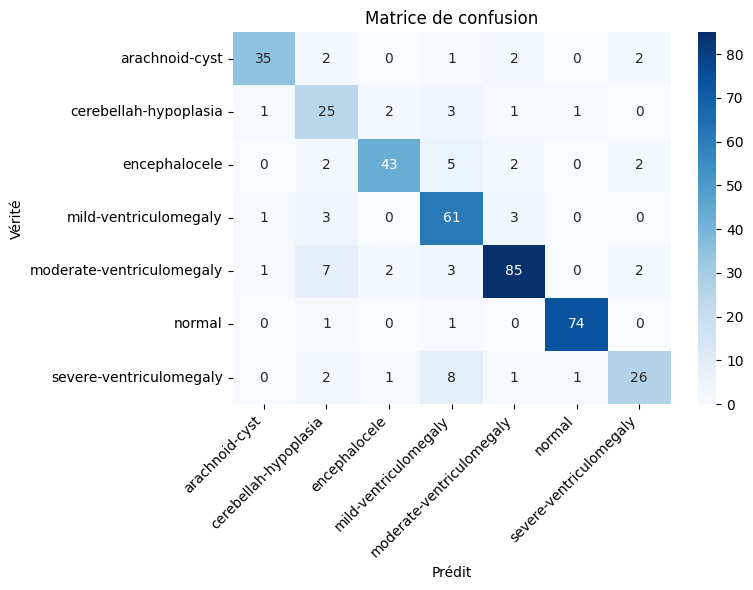

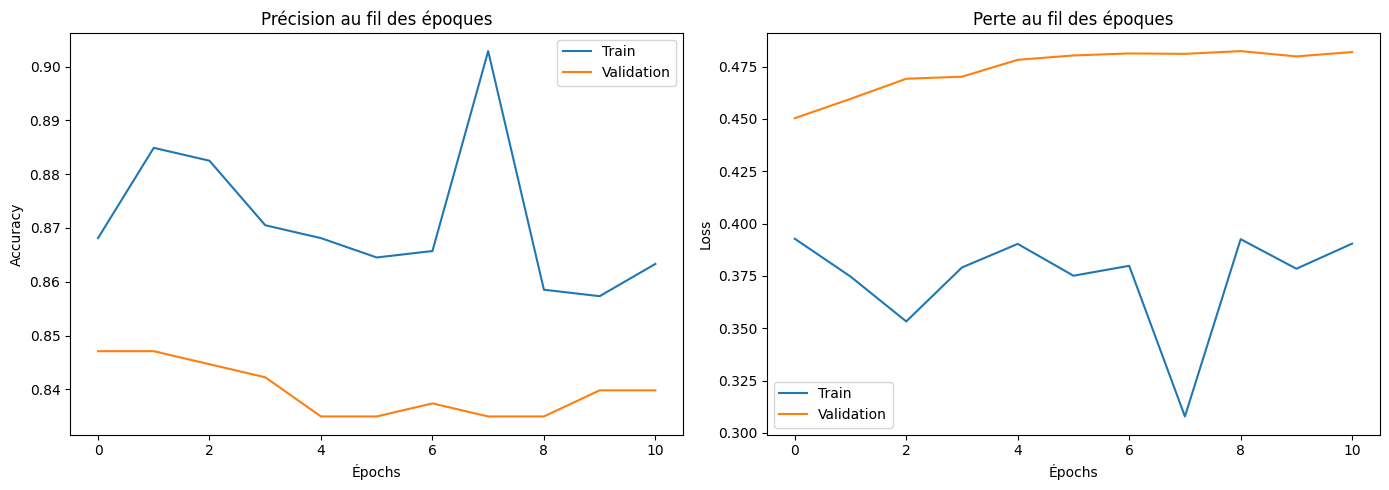

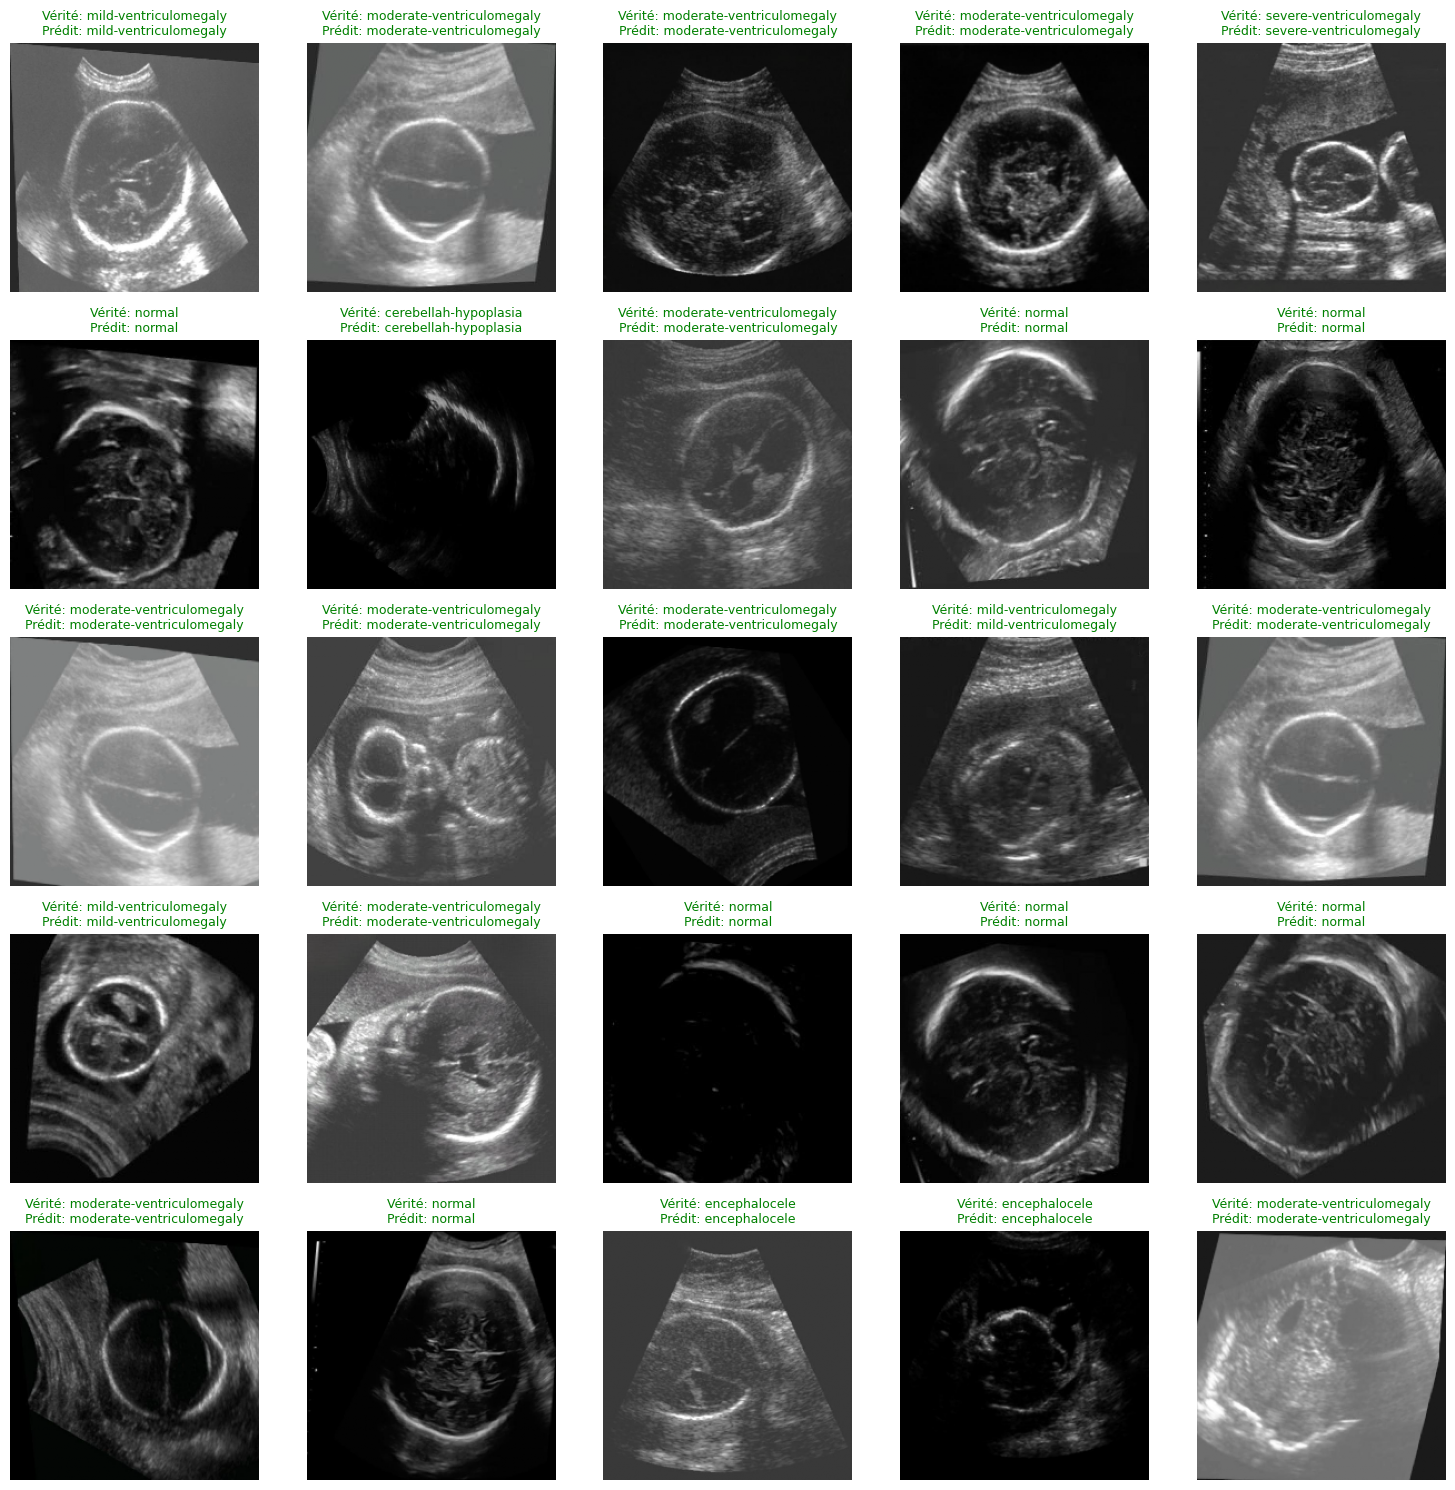

✅ Évaluation terminée avec succès.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Étape 1 : Prédictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# ✅ Étape 2 : Rapport de classification
class_names = [
    'arachnoid-cyst',
    'cerebellah-hypoplasia',
    'encephalocele',
    'mild-ventriculomegaly',
    'moderate-ventriculomegaly',
    'normal',
    'severe-ventriculomegaly',
]

print("✅ Rapport de classification :\n")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# ✅ Étape 3 : Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédit')
plt.ylabel('Vérité')
plt.title('Matrice de confusion')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ✅ Étape 4 : Courbes d’apprentissage
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision au fil des époques')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte au fil des époques')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ✅ Étape 5 : Affichage de quelques exemples avec prédiction
plt.figure(figsize=(15, 15))
for i in range(25):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx]
    true_label = class_names[true_classes[idx]]
    pred_label = class_names[predicted_classes[idx]]
    color = 'green' if true_label == pred_label else 'red'
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Vérité: {true_label}\nPrédit: {pred_label}", color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Évaluation terminée avec succès.")
